In [3]:
import jax
jax.config.update("jax_enable_x64", True)
import s2fft
import healpy as hp
import numpy as np
import s2wav
import s2wav.filters as filters
import matplotlib.pyplot as plt
import os
from astropy.io import fits #For beam deconvolution

In [2]:

# filename_template = ["febecop_ffp10_lensed_scl_cmb_{frequency}_mc_{realization}.fits",
# "COM_SimMap_synchrotron-ffp10-skyinbands-{frequency}_2048_R3.00_full.fits",
# "ffp10_noise_{frequency}_full_map_mc_{realization}.fits"] 
# directory = 'CMB_realizations'
# frequencies = ["030", "044", "070", "100", "143", "217", "353", "545", "857"]  # Example frequencies


# L= read_healpix_map("CMB_realizations/febecop_ffp10_lensed_scl_cmb_030_mc_0000.fits", "100", plot = True).shape[0]

Processing maps for frequency 100 and realization 0


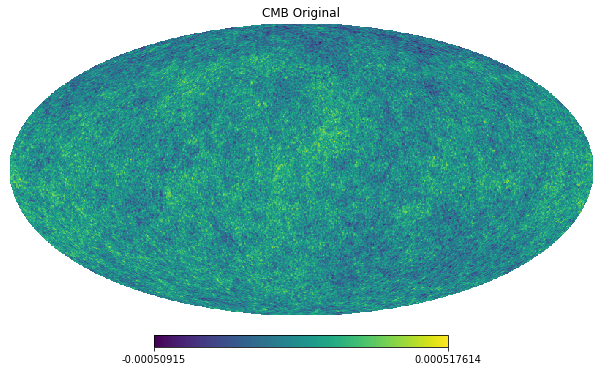

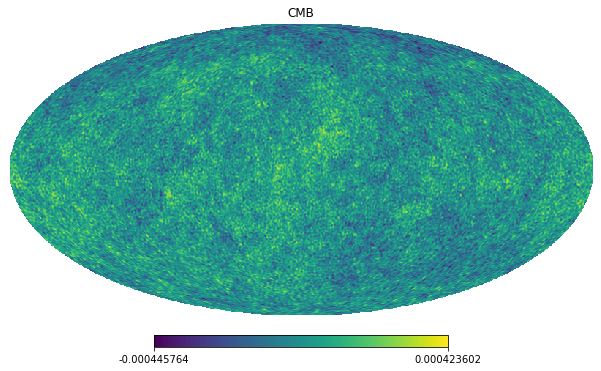

In [6]:
def hp_map_2_hp_alm(healpix_map, L_max):
    hp_alm = hp.map2alm(healpix_map, lmax=L_max - 1)
    return hp_alm

def hp_alm_2_mw_alm(hp_alm, L_max):
    MW_alm = np.zeros((L_max, 2 * L_max - 1), dtype=np.complex128)

    for l in range(L_max):
        for m in range(-l, l + 1):
            index = hp.Alm.getidx(L_max - 1, l, abs(m))
            if m < 0:
                MW_alm[l, L_max + m - 1] = (-1) ** m * np.conj(hp_alm[index])
            else:
                MW_alm[l, L_max + m - 1] = hp_alm[index]

    return MW_alm



def read_healpix_map(CMB_map_path, frequency, plot = False):
    original_healpix_map = hp.read_map(CMB_map_path)
    if frequency == "545":
        original_healpix_map = original_healpix_map/58.0356
    if frequency == "857":
        original_healpix_map = original_healpix_map/2.2681
    
    if plot:
        hp.mollview(
            original_healpix_map,
            coord=["G"],
            title="Full Sky CMB",
            unit=r"$μ$K",
            # min=-300,
            # max=300,
        )
        plt.show()
    return original_healpix_map

# Convert arcminutes to radians
def arcmin_to_radians(arcmin):
    return np.radians(arcmin / 60)

def reduce_hp_map_resolution(map_data, lmax, nside):
    """
    Processes a Healpix map by converting it to spherical harmonics and back,
    and reducing the resolution.
    
    Args:
        map_data (numpy.ndarray): Input map data.
        lmax (int): Maximum multipole moment for spherical harmonics.
        nside (int): Desired nside resolution for the output map.
        
    Returns:
        numpy.ndarray: Processed map data.
    """
    alm = hp.map2alm(map_data, lmax=lmax)
    processed_map = hp.alm2map(alm, nside=nside)
    return processed_map, alm

def save_map(map_data, map_type, frequency, lmax, realization):
    """
    Saves the processed map to a file with a specific naming convention.
    
    Args:
        map_data (numpy.ndarray): Map data to be saved.
        map_type (str): Type of the map (e.g., "CMB", "Synchrotron", "Noise", "CSN").
        frequency (str): Frequency identifier.
        lmax (int): Maximum multipole moment used in processing.
        realization (str): Realization identifier.
    """
    filename = f"CMB_total/{map_type}_HP_Map_F{frequency}_L{lmax}_R{realization}.fits"
    # hp.mollview(map_data, coord=["G"], title=f"{map_type} Map" +f"F {frequency}", unit=r"$μ$K")
    # plot
    hp.write_map(filename, map_data,dtype="float64", overwrite=True)
    print(f"Map saved to {filename}")


def beam_deconvolution(hp_map, frequency, lmax, standard_fwhm_rad, beam_path):
    """
    Performs beam deconvolution on the given CMB map data and returns the deconvolved map.

    Args:
        cmb_map (fits): CMB map data.
        frequency (str): Frequency identifier (e.g., "030", "044").
        lmax (int): Maximum multipole moment.
        standard_fwhm_rad (float): Standard beam full-width half-maximum in radians.
        beam_path (str): Path to the beam data file specific to the frequency.

    Returns:
      deconvolved_map (fits): The deconvolved CMB map.
    """
    nside = hp.get_nside(hp_map)
    cmb_alm = hp.map2alm(hp_map, lmax=lmax)

    # Define beam full-width half-maximum (FWHM) in arcminutes for some frequencies
    LFI_beam_fwhm = {"030": 32.33, "044": 27.01, "070": 13.25}
    
    # Standard beam for the desired FWHM
    Standard_bl = hp.sphtfunc.gauss_beam(standard_fwhm_rad, lmax=lmax-1, pol=False)
    
    # Pixel window function
    pixwin = hp.sphtfunc.pixwin(nside, lmax=lmax, pol=False)
    
    # LFI beam deconvolution
    if frequency in {"030", "044", "070"}:
        # Deconvolution for lower frequencies
        fwhm_rad = np.radians(LFI_beam_fwhm[frequency] / 60)
        bl = hp.sphtfunc.gauss_beam(fwhm_rad, lmax=lmax-1, pol=False)
        new_cmb_alm = hp.almxfl(cmb_alm, 1/bl)
    # HFI beam deconvolution
    else:
        # Deconvolution using FITS file for higher frequencies
        hfi = fits.open(beam_path)
        beam = hfi[1].data["TEMPERATURE"]
        new_cmb_alm = hp.almxfl(cmb_alm, 1/beam)
    
    # Apply pixel window function and standard beam
    new_cmb_alm = hp.almxfl(new_cmb_alm, 1/pixwin)
    new_cmb_alm = hp.almxfl(new_cmb_alm, Standard_bl)
    
    # Convert back to map
    deconvolved_map = hp.alm2map(new_cmb_alm, nside=nside)
    
    return deconvolved_map



def process_and_save_all_maps(frequencies, realizations, desired_lmax, directory="CMB_realizations"):
    """
    Processes and saves the CMB, Synchrotron, and Noise maps for all specified
    frequencies and realizations, then combines them.
    
    Args:
        frequencies (list): List of frequency identifiers.
        realizations (list): List of realization identifiers.
        lmax (int): Maximum multipole moment for spherical harmonics.
        directory (str): Directory containing the input map files.
    """
    for frequency in frequencies:
        for realization in realizations:
            
            # path = f"CMB_total/CSN_HP_Map_F{frequency}_L{desired_lmax}_R{realization:04d}.fits"
            # if os.path.exists(path):
            #     print(f"File {path} already exists. Skipping download.")
                
            #     continue
                
            print(f"Processing maps for frequency {frequency} and realization {realization}")
            
            # Define file paths
            cmb_file = f"{directory}/febecop_ffp10_lensed_scl_cmb_{frequency}_mc_{realization:04d}.fits"
            synchrotron_file = f"{directory}/COM_SimMap_synchrotron-ffp10-skyinbands-{frequency}_2048_R3.00_full.fits"
            noise_file = f"{directory}/ffp10_noise_{frequency}_full_map_mc_{realization:05d}.fits"
            
            # Read maps
            cmb = read_healpix_map(cmb_file, frequency)

            # hp.mollview(cmb, title = "CMB Original")
            HFI_beam_path = "../../CMB_plot/BeamWf_HFI_R3.01/"+ f"Bl_T_R3.01_fullsky_{frequency}x{frequency}.fits"
            
        
            beam_decon_cmb = beam_deconvolution(cmb, frequency, desired_lmax, arcmin_to_radians(5), HFI_beam_path)
            hp.mollview(beam_decon_cmb, title = "CMB")
            
            # np.save(f"{directory}/febecop_ffp10_lensed_scl_cmb_{frequency}_mc_{realization:04d}.fits", cmb)    
            
            # hp.mollview(cmb, title = "CMB Deconvolved")    


            synchrotron = read_healpix_map(synchrotron_file, frequency)
            noise = read_healpix_map(noise_file, frequency)
            
            # # Calculate nside based on lmax
            nside = desired_lmax // 2
            
            # # Process maps
            # if frequency == "100":
            #     new_cmb, cmb_hp_alm = reduce_hp_map_resolution(cmb, desired_lmax, nside)
            #     # Save for mask:
            #     cmb_MW_alm = hp_alm_2_mw_alm(cmb_hp_alm, desired_lmax)
            #     MW_Pix = s2fft.inverse(cmb_MW_alm, desired_lmax)
            #     np.save(f"U-Net/data/all_masks/mask_R{realization:04d}.npy", MW_Pix)

            
            # new_cmb,_ = reduce_hp_map_resolution(cmb, desired_lmax, nside)
            # new_synchrotron,_  = reduce_hp_map_resolution(synchrotron, desired_lmax, nside)
            # new_noise,_  = reduce_hp_map_resolution(noise, desired_lmax, nside)
            
            



            # # Save processed maps
            # save_map(new_cmb, "CMB", frequency, desired_lmax, f"{realization:04d}")
            # save_map(new_synchrotron, "Synchrotron", frequency, desired_lmax, f"{realization:04d}")
            # save_map(new_noise, "Noise", frequency, desired_lmax, f"{realization:05d}")
            
            # # Combine and save the total map
            # csn = new_cmb + new_synchrotron + new_noise
            # hp.mollview(csn, coord=["G"], title="Total Map")
            # save_map(csn, "CSN", frequency, desired_lmax, f"{realization:04d}")

# # Define frequencies and realizations
# frequencies = ["030", "044", "070", "100", "143", "217", "353", "545", "857"]
# # frequencies = ["030", "044"]
frequencies = ["100"]
realizations = list(range(1))  # Realizations from 0 to 9

# # Example usage with user-defined lmax
process_and_save_all_maps(frequencies, realizations, desired_lmax=256)


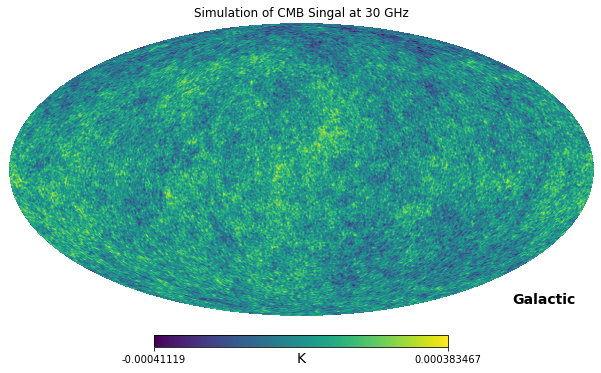

<Figure size 7200x4800 with 0 Axes>

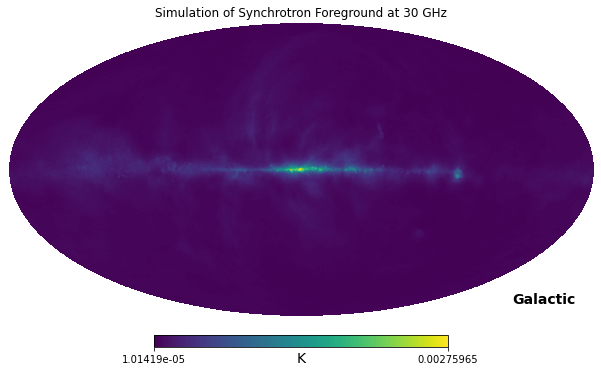

<Figure size 7200x4800 with 0 Axes>

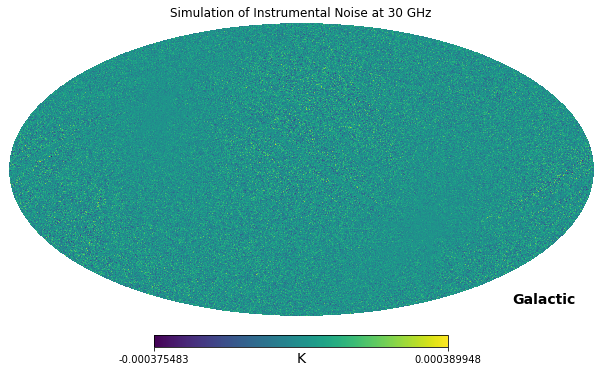

<Figure size 7200x4800 with 0 Axes>

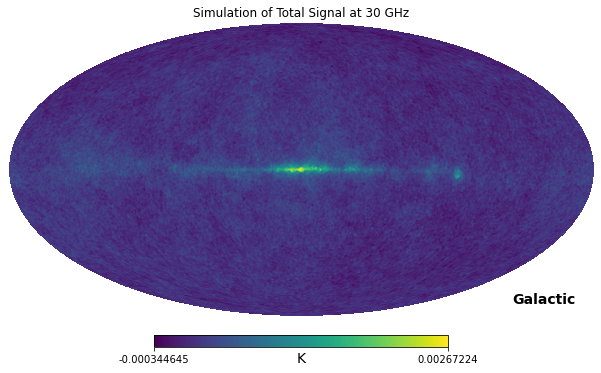

<Figure size 7200x4800 with 0 Axes>

<Figure size 7200x4800 with 0 Axes>

In [19]:
def read_healpix_map(CMB_map_path, frequency, plot = False):
    original_healpix_map = hp.read_map(CMB_map_path)
    # if frequency == "545":
    #     original_healpix_map = original_healpix_map/58.0356
    # if frequency == "857":
    #     original_healpix_map = original_healpix_map/2.2681
    
    if plot:
        hp.mollview(
            original_healpix_map,
            coord=["G"],
            title=frequency,
            unit=r"K",
            xsize = 3000
            # min=-300,
            # max=300,

        )
        plt.figure(dpi=1200)
        plt.show()
    return original_healpix_map

# Define frequencies and realizations
# frequencies = ["030", "044", "070", "100", "143", "217", "353", "545", "857"]
frequencies = ["030"]
# frequencies = ["100"]
realizations = list(range(1))  # Realizations from 0 to 9

for frequency in frequencies:
        for realization in realizations:
            # path = f"CMB_total/Noise_HP_Map_F{frequency}_L{256}_R{realization:05d}.fits"
            # path1 = f"CMB_total/Synchrotron_HP_Map_F{frequency}_L{256}_R{realization:04d}.fits"
            synchrotron_path = "CMB_realizations/COM_SimMap_synchrotron-ffp10-skyinbands-030_2048_R3.00_full.fits"
            noise_path = "CMB_realizations/ffp10_noise_030_full_map_mc_00000.fits"
            # Read maps
            # cmb = read_healpix_map(cmb_file, frequency)
            CMB_path = "CMB_realizations/febecop_ffp10_lensed_scl_cmb_030_mc_0000.fits"
            cmb = read_healpix_map(CMB_path, "Simulation of CMB Singal at 30 GHz", True)
            synchrotron = read_healpix_map(synchrotron_path, "Simulation of Synchrotron Foreground at 30 GHz", True)
            noise = read_healpix_map(noise_path,"Simulation of Instrumental Noise at 30 GHz", True)

            CSN = "CMB_total/CSN_HP_Map_F030_L256_R0000.fits"
            # "../data/planck_simulation/ffp10_newdust_total_030_full_map.fits"
            
            read_healpix_map(CSN, "Simulation of Total Signal at 30 GHz", True)
            
            # hp.mollview(CSN, coord=["G"], title="Planck data", unit=r"K")
            plt.figure(dpi=1200)
            plt.show()
            

In [18]:
from astropy.io import fits
hfi = fits.open("/home/max/CMB_plot/code/CMB_realizations/febecop_ffp10_lensed_scl_cmb_030_mc_0000.fits")
# /home/max/CMB_plot/code/CMB_realizations/febecop_ffp10_lensed_scl_cmb_030_mc_0000.fits

In [ ]:
print(hfi.info())

print(hfi[1].header)    

Filename: /home/max/CMB_plot/code/CMB_realizations/febecop_ffp10_lensed_scl_cmb_030_mc_0000.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       7   ()      
  1  FULL SKY MAP    1 BinTableHDU     55   12288R x 3C   [1024E, 1024E, 1024E]   
None
XTENSION= 'BINTABLE'           / binary table extension                         BITPIX  =                    8 / 8-bit bytes                                    NAXIS   =                    2 / 2-dimensional binary table                     NAXIS1  =                12288 / width of table in bytes                        NAXIS2  =                12288 / number of rows in table                        PCOUNT  =                    0 / size of special data area                      GCOUNT  =                    1 / one data group (required keyword)              TFIELDS =                    3 / number of fields in each row                   COMMENT                                                       

In [ ]:
# def hp_map_2_hp_alm(healpix_map, L_max):
#     hp_alm = hp.map2alm(healpix_map, lmax=L_max - 1)
#     return hp_alm

# def hp_alm_2_mw_alm(hp_alm, L_max):
#     MW_alm = np.zeros((L_max, 2 * L_max - 1), dtype=np.complex128)

#     for l in range(L_max):
#         for m in range(-l, l + 1):
#             index = hp.Alm.getidx(L_max - 1, l, abs(m))
#             if m < 0:
#                 MW_alm[l, L_max + m - 1] = (-1) ** m * np.conj(hp_alm[index])
#             else:
#                 MW_alm[l, L_max + m - 1] = hp_alm[index]

#     return MW_alm



# def read_healpix_map(CMB_map_path, frequency, plot = False):
#     original_healpix_map = hp.read_map(CMB_map_path)
#     if frequency == "545":
#         original_healpix_map = original_healpix_map/58.0356
#     if frequency == "857":
#         original_healpix_map = original_healpix_map/2.2681
    
#     if plot:
#         hp.mollview(
#             original_healpix_map,
#             coord=["G"],
#             title="Full Sky CMB",
#             unit=r"$μ$K",
#             # min=-300,
#             # max=300,
#         )
#         plt.show()
#     return original_healpix_map

# # Convert arcminutes to radians
# def arcmin_to_radians(arcmin):
#     return np.radians(arcmin / 60)

# def process_map(map_data, lmax, nside):
#     """
#     Processes a Healpix map by converting it to spherical harmonics and back,
#     and reducing the resolution.
    
#     Args:
#         map_data (numpy.ndarray): Input map data.
#         lmax (int): Maximum multipole moment for spherical harmonics.
#         nside (int): Desired nside resolution for the output map.
        
#     Returns:
#         numpy.ndarray: Processed map data.
#     """
#     alm = hp.map2alm(map_data, lmax=lmax)
#     processed_map = hp.alm2map(alm, nside=nside)
#     return processed_map

# def save_map(map_data, map_type, frequency, lmax, realization):
#     """
#     Saves the processed map to a file with a specific naming convention.
    
#     Args:
#         map_data (numpy.ndarray): Map data to be saved.
#         map_type (str): Type of the map (e.g., "CMB", "Synchrotron", "Noise", "CSN").
#         frequency (str): Frequency identifier.
#         lmax (int): Maximum multipole moment used in processing.
#         realization (str): Realization identifier.
#     """
#     filename = f"CMB_total/{map_type}_HP_Map_F{frequency}_L{lmax}_R{realization}.fits"
#     hp.mollview(map_data, coord=["G"], title=f"{map_type} Map", unit=r"$μ$K")
#     # plot
#     hp.write_map(filename, map_data,dtype="float64", overwrite=True)
#     print(f"Map saved to {filename}")





# def process_and_save_all_maps(frequencies, realizations, lmax, directory="CMB_realizations"):
#     """
#     Processes and saves the CMB, Synchrotron, and Noise maps for all specified
#     frequencies and realizations, then combines them.
    
#     Args:
#         frequencies (list): List of frequency identifiers.
#         realizations (list): List of realization identifiers.
#         lmax (int): Maximum multipole moment for spherical harmonics.
#         directory (str): Directory containing the input map files.
#     """
#     for frequency in frequencies:
#         for realization in realizations:
            
#             path = f"CMB_total/CSN_HP_Map_F{frequency}_L{lmax}_R{realization:04d}.fits"
#             # if os.path.exists(path):
#             #     print(f"File {path} already exists. Skipping download.")
                
                
#             #     continue
                
#             print(f"Processing maps for frequency {frequency} and realization {realization}")
            
#             # Define file paths
#             cmb_file = f"{directory}/febecop_ffp10_lensed_scl_cmb_{frequency}_mc_{realization:04d}.fits"
#             synchrotron_file = f"{directory}/COM_SimMap_synchrotron-ffp10-skyinbands-{frequency}_2048_R3.00_full.fits"
#             noise_file = f"{directory}/ffp10_noise_{frequency}_full_map_mc_{realization:05d}.fits"
            
#             # Read maps
#             cmb = read_healpix_map(cmb_file, frequency)
           
#             # Beam deconvolution
#             beam_fwhm = {"030": 32.33, "044": 27.01, "070": 13.25}
#             # Beam Deconvolution for CMB signal:
#             # hp.mollview(cmb, title = "CMB Original")
#             nside = hp.get_nside(cmb)
#             lmax = nside*2
#             local_path = "../../CMB_plot/BeamWf_HFI_R3.01/"
#             cmb_alm = hp.map2alm(cmb, lmax=lmax)
#             standard_fwhm_rad = arcmin_to_radians(5)
#             Standard_bl = hp.sphtfunc.gauss_beam(standard_fwhm_rad, lmax=lmax-1, pol=False)
#             pixwin = hp.sphtfunc.pixwin(nside, lmax=lmax, pol=False)
            
#             if frequency in {"030", "044", "070"}:
#                 # Decovolution of the beam
#                 fwhm_rad = arcmin_to_radians(beam_fwhm[frequency])
#                 bl = hp.sphtfunc.gauss_beam(fwhm_rad, lmax=lmax-1, pol=False)
#                 new_cmb_alm = hp.almxfl(cmb_alm, 1/bl)

#             else:
#                 # Open the FITS file
#                 hfi = fits.open(local_path + f"Bl_T_R3.01_fullsky_{frequency}x{frequency}.fits")
#                 beam = hfi[1].data["TEMPERATURE"]
#                 new_cmb_alm = hp.almxfl(cmb_alm, 1/beam)
        
#             # Pixel deconvolution
#             new_cmb_alm = hp.almxfl(cmb_alm, 1/pixwin)
#             # Standard beam
#             new_cmb_alm = hp.almxfl(new_cmb_alm, Standard_bl)


#             cmb = hp.alm2map(new_cmb_alm, nside=nside)
            
#             # np.save(f"{directory}/febecop_ffp10_lensed_scl_cmb_{frequency}_mc_{realization:04d}.fits", cmb)    
            
#             hp.mollview(cmb, title = "CMB Deconvolved "+frequency)    


#             synchrotron = read_healpix_map(synchrotron_file, frequency)
#             noise = read_healpix_map(noise_file, frequency)
            
#             # # Calculate nside based on lmax
#             # nside = lmax // 2
            
#             # # Process maps
#             # new_cmb = process_map(cmb, lmax, nside)
#             # new_synchrotron = process_map(synchrotron, lmax, nside)
#             # new_noise = process_map(noise, lmax, nside)
            
#             # # Save processed maps
#             # save_map(new_cmb, "CMB", frequency, lmax, f"{realization:04d}")
#             # save_map(new_synchrotron, "Synchrotron", frequency, lmax, f"{realization:04d}")
#             # save_map(new_noise, "Noise", frequency, lmax, f"{realization:05d}")
            
#             # Combine and save the total map
#             # csn = new_cmb + new_synchrotron + new_noise
#             # hp.mollview(csn, coord=["G"], title="Total Map")
#             # save_map(csn, "CSN", frequency, lmax, f"{realization:04d}")

# # Define frequencies and realizations
# frequencies = ["030", "044", "070", "100", "143", "217", "353", "545", "857"]
# # frequencies = ["030", "044"]
# # frequencies = ["044"]
# realizations = list(range(1))  # Realizations from 0 to 9

# # Example usage with user-defined lmax
# process_and_save_all_maps(frequencies, realizations, lmax=32)


In [ ]:
def process_and_save_all_maps(frequencies, realizations, desired_lmax, directory="CMB_realizations"):
    """
    Processes and saves the CMB, Synchrotron, and Noise maps for all specified
    frequencies and realizations, then combines them.
    
    Args:
        frequencies (list): List of frequency identifiers.
        realizations (list): List of realization identifiers.
        lmax (int): Maximum multipole moment for spherical harmonics.
        directory (str): Directory containing the input map files.
    """
    for frequency in frequencies:
        for realization in realizations:
            
            # path = f"CMB_total/CSN_HP_Map_F{frequency}_L{desired_lmax}_R{realization:04d}.fits"
            # if os.path.exists(path):
            #     print(f"File {path} already exists. Skipping download.")
                
            #     continue
                
            print(f"Processing maps for frequency {frequency} and realization {realization}")
            
            # Define file paths
            cmb_file = f"{directory}/febecop_ffp10_lensed_scl_cmb_{frequency}_mc_{realization:04d}.fits"
            synchrotron_file = f"{directory}/COM_SimMap_synchrotron-ffp10-skyinbands-{frequency}_2048_R3.00_full.fits"
            noise_file = f"{directory}/ffp10_noise_{frequency}_full_map_mc_{realization:05d}.fits"
            
            # Read maps
            cmb = read_healpix_map(cmb_file, frequency)
           
            # Beam deconvolution
            beam_fwhm = {"030": 32.33, "044": 27.01, "070": 13.25}
            # Beam Deconvolution for CMB signal:
            hp.mollview(cmb, title = "CMB Original")
            nside = hp.get_nside(cmb)
            true_lmax = nside*2
            local_path = "../../CMB_plot/BeamWf_HFI_R3.01/"
            cmb_alm = hp.map2alm(cmb, lmax=true_lmax)
            standard_fwhm_rad = arcmin_to_radians(5)
            Standard_bl = hp.sphtfunc.gauss_beam(standard_fwhm_rad, lmax=true_lmax-1, pol=False)
            pixwin = hp.sphtfunc.pixwin(nside, lmax=true_lmax, pol=False)
            if frequency in {"030", "044", "070"}:
                # Decovolution of the beam
                fwhm_rad = arcmin_to_radians(beam_fwhm[frequency])
                bl = hp.sphtfunc.gauss_beam(fwhm_rad, lmax=true_lmax-1, pol=False)
                new_cmb_alm = hp.almxfl(cmb_alm, 1/bl)

            else:
                # Open the FITS file
                hfi = fits.open(local_path + f"Bl_T_R3.01_fullsky_{frequency}x{frequency}.fits")
                beam = hfi[1].data["TEMPERATURE"]
                new_cmb_alm = hp.almxfl(cmb_alm, 1/beam)
        
            # Pixel deconvolution
            new_cmb_alm = hp.almxfl(cmb_alm, 1/pixwin)
            # Standard beam
            new_cmb_alm = hp.almxfl(new_cmb_alm, Standard_bl)


            cmb = hp.alm2map(new_cmb_alm, nside=nside)
            
            # np.save(f"{directory}/febecop_ffp10_lensed_scl_cmb_{frequency}_mc_{realization:04d}.fits", cmb)    
            
            hp.mollview(cmb, title = "CMB Deconvolved")    


            synchrotron = read_healpix_map(synchrotron_file, frequency)
            noise = read_healpix_map(noise_file, frequency)
            
            # # Calculate nside based on lmax
            nside = desired_lmax // 2
            
            # # Process maps
            if frequency == "100":
                new_cmb, cmb_hp_alm = process_map(cmb, desired_lmax, nside)
                # Save for mask:
                cmb_MW_alm = hp_alm_2_mw_alm(cmb_hp_alm, desired_lmax)
                MW_Pix = s2fft.inverse(cmb_MW_alm, desired_lmax)
                np.save(f"U-Net/data/all_masks/mask_R{realization:04d}.npy", MW_Pix)


In [3]:
synchrotron = read_healpix_map("/home/max/CMB_plot/code/CMB_total/Synchrotron_HP_Map_F100_L256_R0000.fits", "100", plot = True)
# standard_fwhm_rad = arcmin_to_radians(5)
# Standard_bl = hp.sphtfunc.gauss_beam(standard_fwhm_rad, lmax=256-1, pol=False)
# print(Standard_bl)



NameError: name 'read_healpix_map' is not defined